In [1]:
import glob
import json
import pyspark.sql.types as T

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [2]:
# Set up the Spark configuration and context
conf = SparkConf().setAppName("MyApp").setMaster("local[*]")
sc = SparkContext(conf=conf)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/03 09:07:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Set up the Spark session
spark = SparkSession.builder \
    .appName("BatchProcessor") \
    .getOrCreate()

In [4]:
# Function to cast values to match schema
def cast_values(record, schema):
    for field in schema.fields:
        if field.name in record:
            if isinstance(record[field.name], int) and isinstance(field.dataType, T.FloatType):
                record[field.name] = float(record[field.name])
            # Add more type checks and casts as needed
    return record

In [5]:
# Path to JSON files
json_files = sorted(glob.glob("/Users/ankit/Desktop/Data_Engineer_IISc/data/ratings_*.json"))

In [6]:
# Define schema
schema = T.StructType([
    T.StructField("authors", T.ArrayType(T.StringType()), True),
    T.StructField("date_google", T.StringType(), True),
    T.StructField("date_metadata", T.StringType(), True),
    T.StructField("date_published", T.StringType(), True),
    T.StructField("date_target", T.StringType(), True),
    T.StructField("description", T.StringType(), True),
    T.StructField("explanation", T.StringType(), True),
    T.StructField("groq_usage", T.StringType(), True),
    T.StructField("metadata", T.MapType(T.StringType(), T.StringType()), True),
    T.StructField("rating_democrats", T.FloatType(), True),
    T.StructField("rating_republicans", T.FloatType(), True),
    T.StructField("source_url", T.StringType(), True),
    T.StructField("summary", T.StringType(), True),
    T.StructField("text", T.StringType(), True),
    T.StructField("title", T.StringType(), True),
    T.StructField("url", T.StringType(), True)
])

In [7]:
# Iterate over files and process each JSON
for json_file in json_files:
    print(f"Processing file: {json_file}")
    
    # Load and cast data
    data = json.load(open(json_file))
    data = [cast_values(record, schema) for record in data]
    
    # Create DataFrame
    df = spark.createDataFrame(data, schema=schema)
    
    # Select intended columns
    selected_columns = ["date_google", "rating_democrats", "rating_republicans", "title", "url"]
    df_selected = df.select(*selected_columns)
    
    # Show the result
    print(f"Data from {json_file}:")
    df_selected.show(n=5, truncate=False)


Processing file: /Users/ankit/Desktop/Data_Engineer_IISc/data/ratings_1732512728.458377.json
Data from /Users/ankit/Desktop/Data_Engineer_IISc/data/ratings_1732512728.458377.json:


+-------------------+----------------+------------------+-------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------+
|date_google        |rating_democrats|rating_republicans|title                                                                                |url                                                                                                                     |
+-------------------+----------------+------------------+-------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------+
|2024-01-02T05:02:55|2.0             |-1.0              |Biden and Trump are poised for a potential rematch that could shake American politics|https://apnews.com/article/biden-trump-election-2024-a6c4a7518

In [8]:
# Define schema for required fields
schema = T.StructType([
    T.StructField("date_google", T.StringType(), True),
    T.StructField("rating_democrats", T.FloatType(), True),
    T.StructField("rating_republicans", T.FloatType(), True)
])

# Iterate over files and process each JSON
for json_file in json_files:
    print(f"Processing file: {json_file}")
    
    # Load and cast data
    data = json.load(open(json_file))
    data = [cast_values(record, schema) for record in data]
    
    # Create DataFrame
    df = spark.createDataFrame(data, schema=schema)
    
    # Show the result
    print(f"Data from {json_file}:")
    df.show(n=5, truncate=False)

Processing file: /Users/ankit/Desktop/Data_Engineer_IISc/data/ratings_1732512728.458377.json
Data from /Users/ankit/Desktop/Data_Engineer_IISc/data/ratings_1732512728.458377.json:
+-------------------+----------------+------------------+
|date_google        |rating_democrats|rating_republicans|
+-------------------+----------------+------------------+
|2024-01-02T05:02:55|2.0             |-1.0              |
|2024-01-02T09:45:21|2.0             |-1.0              |
|2024-01-12T19:38:38|3.0             |-2.0              |
|NULL               |3.0             |-2.0              |
|2024-01-02T05:00:43|1.0             |-1.0              |
+-------------------+----------------+------------------+
only showing top 5 rows

Processing file: /Users/ankit/Desktop/Data_Engineer_IISc/data/ratings_1732512872.008657.json
Data from /Users/ankit/Desktop/Data_Engineer_IISc/data/ratings_1732512872.008657.json:
+-------------------+----------------+------------------+
|date_google        |rating_democra

In [9]:
# Define schema for required fields
schema = T.StructType([
    T.StructField("date_google", T.StringType(), True),
    T.StructField("rating_democrats", T.FloatType(), True),
    T.StructField("rating_republicans", T.FloatType(), True)
])

# Initialize an empty DataFrame
combined_df = spark.createDataFrame([], schema)

# Iterate over files and process each JSON
for json_file in json_files:
    print(f"Processing file: {json_file}")
    
    # Load and cast data
    data = json.load(open(json_file))
    data = [cast_values(record, schema) for record in data]
    
    # Create DataFrame
    df = spark.createDataFrame(data, schema=schema)
    
    # Combine the DataFrame with the existing combined DataFrame
    combined_df = combined_df.unionAll(df)

# Save the combined DataFrame to a CSV file
output_path = "filtered_ratings_data.csv"
combined_df.write.csv(output_path, header=True, mode="overwrite")

print(f"Filtered data saved to {output_path}")

Processing file: /Users/ankit/Desktop/Data_Engineer_IISc/data/ratings_1732512728.458377.json
Processing file: /Users/ankit/Desktop/Data_Engineer_IISc/data/ratings_1732512872.008657.json
Processing file: /Users/ankit/Desktop/Data_Engineer_IISc/data/ratings_1732512991.78657.json
Processing file: /Users/ankit/Desktop/Data_Engineer_IISc/data/ratings_1732513084.556074.json
Processing file: /Users/ankit/Desktop/Data_Engineer_IISc/data/ratings_1732513159.7189.json
Processing file: /Users/ankit/Desktop/Data_Engineer_IISc/data/ratings_1732601761.068841.json
Processing file: /Users/ankit/Desktop/Data_Engineer_IISc/data/ratings_1732601848.275424.json
Processing file: /Users/ankit/Desktop/Data_Engineer_IISc/data/ratings_1732601920.24529.json
Processing file: /Users/ankit/Desktop/Data_Engineer_IISc/data/ratings_1732602008.020645.json
Processing file: /Users/ankit/Desktop/Data_Engineer_IISc/data/ratings_1732602079.182383.json
Processing file: /Users/ankit/Desktop/Data_Engineer_IISc/data/ratings_1732

Filtered data saved to filtered_ratings_data.csv


In [10]:
import pyspark.sql.functions as F

# Path to all CSV files
csv_files_path = "/Users/ankit/Desktop/Data_Engineer_IISc/filtered_ratings_data.csv/*.csv"

# Read all CSV files into a single DataFrame
df = spark.read.option("header", "true").csv(csv_files_path)

# Show schema and sample data
df.printSchema()
df.show(20)


root
 |-- date_google: string (nullable = true)
 |-- rating_democrats: string (nullable = true)
 |-- rating_republicans: string (nullable = true)

+-------------------+----------------+------------------+
|        date_google|rating_democrats|rating_republicans|
+-------------------+----------------+------------------+
|2024-01-16T04:21:40|             0.0|               0.0|
|               NULL|             0.0|               0.0|
|2024-01-24T03:21:12|             0.0|               2.0|
|2024-01-15T21:59:18|             0.0|              -1.0|
|2024-01-16T16:20:49|            -2.0|               4.0|
|2024-01-16T05:19:24|            -3.0|               4.0|
|               NULL|            -1.0|               2.0|
|2024-01-15T03:09:00|             0.0|               0.0|
|2024-01-15T15:25:26|             0.0|               0.0|
|               NULL|            -2.0|               3.0|
|2024-01-15T07:52:23|             0.0|               1.0|
|               NULL|             1.0|   

In [11]:
from pyspark.sql.functions import window, avg

# Convert date_google to timestamp type if not already
df = df.withColumn("date_google", F.col("date_google").cast("timestamp"))

# Aggregate ratings over 1-hour windows
aggregated_ratings = df.groupBy(window("date_google", "1 hour")).agg(
    avg("rating_democrats").alias("avg_rating_democrats"),
    avg("rating_republicans").alias("avg_rating_republicans")
)

# Flatten the window column into start and end times
aggregated_ratings = aggregated_ratings.select(
    F.col("window.start").alias("window_start"),
    F.col("window.end").alias("window_end"),
    "avg_rating_democrats",
    "avg_rating_republicans"
)

aggregated_ratings.show(5, truncate=False)


+-------------------+-------------------+--------------------+----------------------+
|window_start       |window_end         |avg_rating_democrats|avg_rating_republicans|
+-------------------+-------------------+--------------------+----------------------+
|2024-01-06 16:00:00|2024-01-06 17:00:00|1.0                 |-1.0                  |
|2024-06-17 10:00:00|2024-06-17 11:00:00|1.75                |-1.5                  |
|2024-01-19 14:00:00|2024-01-19 15:00:00|0.5                 |0.0                   |
|2024-01-23 05:00:00|2024-01-23 06:00:00|2.0                 |0.5                   |
|2024-01-14 10:00:00|2024-01-14 11:00:00|1.0                 |-2.0                  |
+-------------------+-------------------+--------------------+----------------------+
only showing top 5 rows



In [13]:
from pyspark.sql.functions import col, window, mean
from pyspark.sql.types import TimestampType, DoubleType  # Import TimestampType and DoubleType

# Load and debug stock data
stock_data = spark.read \
    .csv("ticker_data.csv", header=True) \
    .select(col("Date").cast(TimestampType()), col("Close").cast(DoubleType()))

# Filter out rows with NULL values
stock_data = stock_data.filter(col("Date").isNotNull() & col("Close").isNotNull())

# Debugging: Check for valid rows
print("Sample Stock Data After Filtering:")
stock_data.show(5)


Sample Stock Data After Filtering:
+-------------------+------------------+
|               Date|             Close|
+-------------------+------------------+
|2023-11-16 06:30:00| 69.66500091552734|
|2023-11-16 06:30:00| 95.44999694824219|
|2023-11-16 06:30:00|449.95001220703125|
|2023-11-16 06:30:00|62.470001220703125|
|2023-11-16 06:30:00| 79.87999725341797|
+-------------------+------------------+
only showing top 5 rows



In [14]:
from pyspark.sql.functions import window, avg

# Aggregate stock data over 1-hour rolling windows
aggregated_stocks = stock_data.groupBy(window("Date", "1 hour")).agg(
    avg("Close").alias("avg_close_price")
)

# Flatten the window column into start and end times
aggregated_stocks = aggregated_stocks.select(
    col("window.start").alias("window_start"),
    col("window.end").alias("window_end"),
    "avg_close_price"
)

# Debugging: Check the aggregated data
print("Aggregated Stock Data:")
aggregated_stocks.show(5, truncate=False)



Aggregated Stock Data:
+-------------------+-------------------+-----------------+
|window_start       |window_end         |avg_close_price  |
+-------------------+-------------------+-----------------+
|2023-11-28 06:00:00|2023-11-28 07:00:00|755.6583296060562|
|2024-02-02 06:00:00|2024-02-02 07:00:00|815.0045593976974|
|2024-05-31 09:00:00|2024-05-31 10:00:00|878.3265219926834|
|2024-01-04 08:00:00|2024-01-04 09:00:00|782.0383118391037|
|2024-03-06 11:00:00|2024-03-06 12:00:00|846.8331389427185|
+-------------------+-------------------+-----------------+
only showing top 5 rows



In [15]:
from pyspark.sql.functions import col
from pyspark.sql.types import TimestampType, FloatType

# Load the political ratings data
ratings_data = spark.read.csv("filtered_ratings_data.csv", header=True)

# Cast columns to appropriate types
filtered_ratings = ratings_data.select(
    col("date_google").cast(TimestampType()),
    col("rating_democrats").cast(FloatType()),
    col("rating_republicans").cast(FloatType())
)

# Debugging: Show filtered ratings data
print("Filtered Political Ratings Data:")
filtered_ratings.show(5, truncate=False)


Filtered Political Ratings Data:
+-------------------+----------------+------------------+
|date_google        |rating_democrats|rating_republicans|
+-------------------+----------------+------------------+
|2024-01-16 04:21:40|0.0             |0.0               |
|NULL               |0.0             |0.0               |
|2024-01-24 03:21:12|0.0             |2.0               |
|2024-01-15 21:59:18|0.0             |-1.0              |
|2024-01-16 16:20:49|-2.0            |4.0               |
+-------------------+----------------+------------------+
only showing top 5 rows



In [16]:
from pyspark.sql.functions import avg, col, window

# Ensure date_google is cast to TimestampType
filtered_ratings = filtered_ratings.withColumn("date_google", col("date_google").cast(TimestampType()))

# Aggregate ratings data over 1-hour windows
aggregated_ratings = filtered_ratings.groupBy(window("date_google", "1 hour")).agg(
    avg("rating_democrats").alias("avg_rating_democrats"),
    avg("rating_republicans").alias("avg_rating_republicans")
)

# Flatten the window column
aggregated_ratings = aggregated_ratings.select(
    col("window.start").alias("window_start"),
    col("window.end").alias("window_end"),
    "avg_rating_democrats",
    "avg_rating_republicans"
)

# Debugging: Show aggregated ratings data
print("Aggregated Political Ratings Data:")
aggregated_ratings.show(5, truncate=False)



Aggregated Political Ratings Data:
+-------------------+-------------------+--------------------+----------------------+
|window_start       |window_end         |avg_rating_democrats|avg_rating_republicans|
+-------------------+-------------------+--------------------+----------------------+
|2024-01-06 16:00:00|2024-01-06 17:00:00|1.0                 |-1.0                  |
|2024-06-17 10:00:00|2024-06-17 11:00:00|1.75                |-1.5                  |
|2024-01-19 14:00:00|2024-01-19 15:00:00|0.5                 |0.0                   |
|2024-01-23 05:00:00|2024-01-23 06:00:00|2.0                 |0.5                   |
|2024-01-14 10:00:00|2024-01-14 11:00:00|1.0                 |-2.0                  |
+-------------------+-------------------+--------------------+----------------------+
only showing top 5 rows



In [17]:

from pyspark.sql.functions import col, avg, window

# Aggregate stock data over 1-hour windows
aggregated_stock = stock_data.groupBy(
    window(col("Date"), "1 hour").alias("time_window")
).agg(
    avg("Close").alias("avg_close_price")
)

# Flatten the window column
aggregated_stock = aggregated_stock.select(
    col("time_window.start").alias("window_start"),
    col("time_window.end").alias("window_end"),
    "avg_close_price"
)

# Debugging: Show aggregated stock data
print("Aggregated Stock Data:")
aggregated_stock.show(5, truncate=False)


Aggregated Stock Data:
+-------------------+-------------------+-----------------+
|window_start       |window_end         |avg_close_price  |
+-------------------+-------------------+-----------------+
|2023-11-28 06:00:00|2023-11-28 07:00:00|755.6583296060562|
|2024-02-02 06:00:00|2024-02-02 07:00:00|815.0045593976974|
|2024-05-31 09:00:00|2024-05-31 10:00:00|878.3265219926834|
|2024-01-04 08:00:00|2024-01-04 09:00:00|782.0383118391037|
|2024-03-06 11:00:00|2024-03-06 12:00:00|846.8331389427185|
+-------------------+-------------------+-----------------+
only showing top 5 rows



In [18]:
# Join aggregated ratings and stock data on window_start and window_end
merged_data = aggregated_ratings.join(
    aggregated_stock,
    on=["window_start", "window_end"],
    how="inner"
)

# Debugging: Show the merged data
print("Merged Data:")
merged_data.show(5, truncate=False)


Merged Data:
+-------------------+-------------------+--------------------+----------------------+-----------------+
|window_start       |window_end         |avg_rating_democrats|avg_rating_republicans|avg_close_price  |
+-------------------+-------------------+--------------------+----------------------+-----------------+
|2024-05-31 09:00:00|2024-05-31 10:00:00|3.0                 |-2.0                  |878.3265219926834|
|2024-06-05 08:00:00|2024-06-05 09:00:00|2.0                 |-2.0                  |902.2216369509697|
|2024-06-17 10:00:00|2024-06-17 11:00:00|1.75                |-1.5                  |931.9257143139839|
|2024-04-24 08:00:00|2024-04-24 09:00:00|4.0                 |-3.0                  |837.4006263613701|
|2024-05-24 09:00:00|2024-05-24 10:00:00|1.0                 |-1.0                  |896.1491864323616|
+-------------------+-------------------+--------------------+----------------------+-----------------+
only showing top 5 rows



In [20]:
# Save the merged data to a CSV file
merged_data.write.csv("merged_data-new.csv", header=True)


In [23]:
# Summary statistics for the merged data
merged_data.describe().show()


+-------+--------------------+----------------------+------------------+
|summary|avg_rating_democrats|avg_rating_republicans|   avg_close_price|
+-------+--------------------+----------------------+------------------+
|  count|                 524|                   524|               524|
|   mean|  0.9746967011995639|  -0.46512177390039977| 894.3645452487332|
| stddev|   1.706439617039792|    1.5083683466405164|56.074065195312215|
|    min|                -4.0|                  -5.0| 777.0156936645508|
|    max|                 5.0|                   4.5|1023.8790653347969|
+-------+--------------------+----------------------+------------------+



In [24]:
from pyspark.sql.functions import corr

# Correlation between stock prices and political ratings
merged_data.select(corr("avg_close_price", "avg_rating_democrats").alias("Corr_Stock_Democrats"),
                   corr("avg_close_price", "avg_rating_republicans").alias("Corr_Stock_Republicans")).show()


+--------------------+----------------------+
|Corr_Stock_Democrats|Corr_Stock_Republicans|
+--------------------+----------------------+
|-0.03535162686011002|  0.016644275338456617|
+--------------------+----------------------+



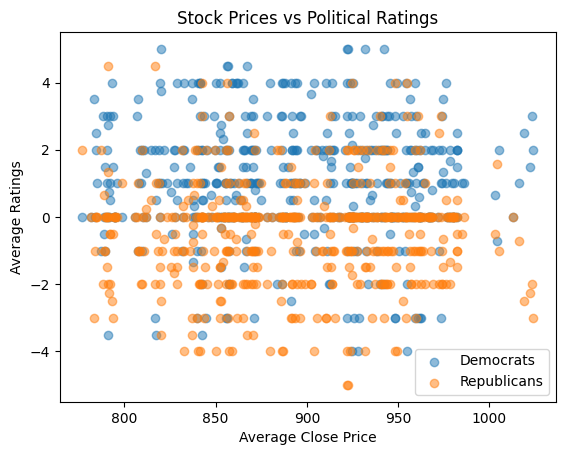

In [25]:
# Collect data for plotting
pandas_df = merged_data.toPandas()

import matplotlib.pyplot as plt

# Scatter plot
plt.scatter(pandas_df["avg_close_price"], pandas_df["avg_rating_democrats"], alpha=0.5, label="Democrats")
plt.scatter(pandas_df["avg_close_price"], pandas_df["avg_rating_republicans"], alpha=0.5, label="Republicans")
plt.xlabel("Average Close Price")
plt.ylabel("Average Ratings")
plt.legend()
plt.title("Stock Prices vs Political Ratings")
plt.show()
